<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_13_2D_to_3D_camera_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

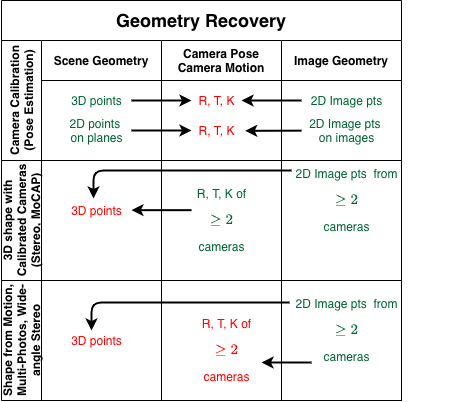

# Topic: Camera Calibration (Pose Estimation)

Section 6.2 of the textbook.

Camera calibration involves the estimation of the *intrinsic* and *extrinsic* parameters. For most applications, the intrinsic parameters, once estimated, can be reused, except for cameras with zoom whose focal length changes for any change in zoom. However, we will need to re-estimate the extrinsic parameters or each placement of the camera. 

Extrinsic parameter estimation, which involves the computation of the rotation and translation from world coordinates to camera coordinates, is similar to another problem in computer vision, namely, **pose estimation**. The pose estimation problem involves assessing rotation and translation to align a 3D model of an object to the image. The underlying technical problem is the same in both cases.

**External References:**

1. R. Tsai, "[A versatile camera calibration technique for high-accuracy 3D machine vision metrology using off-the-shelf TV cameras and lenses](https://ieeexplore.ieee.org/abstract/document/1087109?casa_token=4tTww9X2o_0AAAAA:GL38gGlKjDMukBkdwb7dsx8CHI2zo8yZWBikfvw6M1CvA1xOzit71iGdeqm-GE6C2AZFggWr)," in IEEE Journal on Robotics and Automation, vol. 3, no. 4, pp. 323-344, August 1987, doi: 10.1109/JRA.1987.1087109.

2. B. K. P Horn, "[Tsai’s camera calibration method revisited](http://people.csail.mit.edu/bkph/articles/Tsai_Revisited.pdf)."

3. Aaron T. Becker's Robot Swarm Lab (2021). Calibrate Camera with one Photo (Linear Method), [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/73079-calibrate-camera-with-one-photo-linear-method). Retrieved February 20, 2021. 



# 3D rotations

See Section 2.1.4 of the textbook.

* There are many different ways to represent a 3D rotation matrix. You are probably most familiar with the Euler angle representation. 

**[Euler angles](https://en.wikipedia.org/wiki/Euler_angles)**: A rotation matrix can be formed as the product of three rotations around three cardinal axes, e.g., $x$, $y$, and $z$, or $x$, $y$, and $x$. This representation has serious issues:

>> The result depends on the order in which the transforms are applied.
>> The space of the angles is NOT uniform, and we cannot move smoothly in the space of angles. Look up Gimble lock.






**[Axis/angle (exponential twist)](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation)**: A rotation can be represented by a rotation axis, $\hat{\mathbf{n}}$ and an angle, $\theta$, or equivalently by a 3D vector $\omega = \theta \hat{\mathbf{n}}$. **This is a minimal representation for a 3D rotation.**  BUT,
>> The representation is not unique: $\theta \hat{\mathbf{n}}$, $ (\theta + 2 \pi) \hat{\mathbf{n}}$, and $(-\theta)(-\hat{\mathbf{n}})$, all represent the same rotation.

* The rotation matrix $R(\hat{\mathbf{n}}, \theta)$ representing a finite rotation can be shown to be equal to $\exp (\theta[\hat{\mathbf{n}}]_{\times})$, where $[\hat{\mathbf{n}}]_{\times}$ is a 3 by 3 matrix given by 
$\begin{bmatrix} 
0 & -\hat{n}_z & \hat{n}_y \\
\hat{n}_z & 0 & -\hat{n}_x \\
-\hat{n}_y & \hat{n}_x & 0 
\end{bmatrix}$

* (Question) What is the relationship of this 3 by 3 matrix to cross products? Find out! It will help you compute cross products with just one matrix multiply. 

* For small rotations, this rotation matrix can be shown to simply.
\begin{eqnarray}
\mathbf{R}(\omega) & \approx & 
\begin{bmatrix} 
1 & -\omega_z & \omega_y \\
\omega_z & 1 & -\omega_x \\
-\omega_y & \omega_x & 1 
\end{bmatrix} \\
& = & \mathbf{I} +
\begin{bmatrix} 
0 & -\omega_z & \omega_y \\
\omega_z & 0 & -\omega_x \\
-\omega_y & \omega_x & 0
\end{bmatrix} \\
\end{eqnarray}

**[Unit quaternions](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation)** is a generalization of angle/axis notation. A unit
quaternion is a unit length 4-vector whose components can be written as $ \mathbf{q} = \begin{bmatrix} q_x \\ q_y \\ q_z\\ q_w \end{bmatrix}$, whose magnitude is 1. This 4-d representation is also sometimes represented as a combination of a 3-d vector and a scalar, $(\mathbf{v}, w)$. 

* Quaternions can be derived from the axis/angle representation through the formula: $ \mathbf{q} = (\mathbf{v}, w) = \left [ \sin(\frac{\theta}{2}) \hat{\mathbf{n}}, \cos(\frac{\theta}{2}) \right ]$

* These quaternions live on the unit sphere. Antipodal
(opposite sign) quaternions, $\mathbf{q}$ and $-\mathbf{q}$, represent the same rotation. Other than this issue, the representation is unique and has several important mathematical properties.

>> * The representation is continuous, i.e., as rotation matrices vary continuously.
>> * Multiplication and division of two quaternions can be performed using algebraic forms. See Eq. 2.42 and 2.43 in the textbook.

>> * And more importantly, it is easy to interpolate between two rotations. (Eq. 2.45)


# Calibration problem setup and solution

Without the lens distortion,  the transformation of the 3D point to the image point (in homogeneous coordinates) is a product of a 3 by 3 intrinsic camera parameter $\mathbf{K}$ and a 3 by 4 extrinsic parameter matrix composed of a 3 by 3 rotation matrix, $\mathbf{R}$, and a 3 by 1 translation vector $\mathbf{t}$.

\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} -f & 0 & c_x  \\ 0 & -af & c_y  \\ 0 & 0 & 1  \end{bmatrix}
    \begin{bmatrix} 
    r_{00} & r_{01} & r_{02} & t_x \\ 
    r_{10} & r_{11} & r_{12} & t_y \\
    r_{20} & r_{21} & r_{22} & t_z 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    \mathbf{\tilde{x}}_c & = & \mathbf{K} \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix} \mathbf{\tilde{p}} 
\end{eqnarray}



The task of calibration is to be able to derive the intrinsic $\mathbf{K}$ and extrinsic parameters, $\begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}$, given pairs  consisting of 3D points, with respect to the world, $\mathbf{\tilde{X}}_p$, and their imaged location in terms of row and column in the image, $\mathbf{\tilde{x}}_c$. We will break up this estimation into two steps. 

* First, we will estimate the lumped parameters of the intrinsic and extrinsic parts. 
* Second, we will disentangle these in intrinsic and extrinsic parts from the lumped parameter estimates using linear algebra.

The extrinsic and intrinsic matrices can be multiplied together into one lump parameter matrix $\mathbf{P} = \begin{bmatrix} \mathbf{K} \mathbf{R} & \mathbf{K}  \mathbf{t} \end{bmatrix} $.

\begin{eqnarray} 
    \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} & = &
    \begin{bmatrix} 
    p_{00} & p_{01} & p_{02} & p_{03} \\
    p_{10} & p_{11} & p_{12} & p_{13} \\
    p_{20} & p_{21} & p_{22} & p_{23} 
    \end{bmatrix}
    \begin{bmatrix}
    X_p \\ Y_p \\ Z_p \\ 1
    \end{bmatrix} \\
    x = \frac{x_1}{x_3} & = & \frac{p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
    y = \frac{x_1}{x_3} & = & \frac{p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
\end{eqnarray}

The first problem is to estimate the $p_{ij}$'s given $N$ pairs of 2D and 3D point correspondences, $\{(x_i, y_i), (X_i, Y_i, Z_i) | i = 1, \cdots, N \}$

This problem is similar to estimating the perspective transform estimation for 2D points that we had looked at earlier. Like before, it will involve nonlinear least squares estimation process. The difference here is the size of the parameter matrix. We have 12 unknown parameters here as opposed to nine in the other case. Estimation is a nonlinear one. The strategy we can adopt is nonlinear least-squares involving the following steps. 

1. Form an initial estimate of the $p_{ij}$'s using DLT.
2. Perform nonlinear least-squares refinement of this estimate.
3. Use RQ decomposition to estimate $\mathbf{K}$, $\mathbf{R}$, and $\mathbf{t}$ the $\mathbf{P}$ matrix. 
4. Non-linear optimization using all the parameters, including lens distortion parameters

Note estimation of lens distortion figures only at the last step.

# Step 1: Estimate $p_{ij}$'s using Direct Linear Transform (DLT)

We can rewrite the projective equation 
\begin{eqnarray}
    x = \frac{x_1}{x_3} & = & \frac{p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
    y = \frac{x_1}{x_3} & = & \frac{p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}}{p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}} \\
\end{eqnarray}

as

\begin{eqnarray}
    x ({p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}})& = & {p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}} \\
    y (p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}) & = & {p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}} \\
\end{eqnarray}.

The above equations are equivalent to

\begin{eqnarray}
    {p_{00} X_p + p_{01} Y_p + p_{02} Z_p + p_{03}} - x ({p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23}})  & = & 0\\
    {p_{10} X_p + p_{11} Y_p + p_{12} Z_p + p_{13}} - y (p_{20} X_p + p_{21} Y_p + p_{22} Z_p + p_{23})  & = & 0\\
\end{eqnarray}.

In matrix form, the above equations are:

\begin{eqnarray}
   \begin{bmatrix}
    X_p & Y_p & Z_p & 1 & 0 & 0 & 0 & 0 & -x X_p & - x Y_p & -x Z_p & -x \\
    0 & 0 & 0 & 0 & X_p & Y_p & Z_p & 1 & -y X_p & - y Y_p & -y Z_p & -y
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

We will have two equations per corresponding point. For $N$ pairs of corresponding (2D and 3D) points $(\mathbf{x_i}, \mathbf{X_i})$, we can organize them as multiplication of one $2N \times 12$ matrix with a $12 \times 1$ matrix. 

\begin{eqnarray}
   \begin{bmatrix}
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
      \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

We can further organize the rows of left matrix to cluster the first equation for each corresponding pairs into the first set of rows, followed by all the second equations.

\begin{eqnarray}
   \begin{bmatrix}
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
   \begin{bmatrix}
    p_{00} \\ p_{01} \\ p_{02} \\ p_{03} \\ p_{10} \\ p_{11} \\ p_{12} \\ p_{13} \\ p_{20} \\ p_{21} \\ p_{22} \\ p_{23} 
   \end{bmatrix} & = & 0
\end{eqnarray}

Using $\mathbf{A}$ to denote the left matrix, which is known, and the vector $\mathbf{p}$ for the parameters, which is unknown, we have

\begin{equation}
\mathbf{A} \mathbf{p} = 0
\end{equation}

One way to structure the estimation problem is to pick a $\mathbf{p}$ such that the above equation is satisfied. However, as you will note, we have scaling uncertainty. If $\mathbf{p_1}$ satisfies the above equation, then a scaled version of it, $c\mathbf{p_1}$, also satisfies the equation. Additionally, $\mathbf{p} = 0$ is a degenerate solution! 

To avoid this ill-conditioning of the estimation problem, we have two possible strategies. The first strategy involves fixing one of the components of the parameter vector to 1. Typically, we choose $p_{34}=1$, which represents the $z$-component of the translation vector, $t_z$. Since the $z$-axis points out of the camera into the world, $t_z$ is non-zero. With one component fixed, the estimation problem is now over 11 parameters and the estimation equations can be recast in the form $\mathbf{B}\mathbf{p'} = \mathbf{b}$, where $\mathbf{b}$ involves the terms with $p_{34} (= 1)$. This linear form can be solved using linear methods we had studied earlier in the context of affine transformations.

The second strategy is to find the smallest singular vector of the set of linear equations. This is what we will outline here so that you are aware of both methods. We cast the estimation problem as a minimization problem with the constraint that does not allow the degenerate solution of $\mathbf{p}=0$.

\begin{equation}
\min_{\mathbf{p}} ||\mathbf{A} \mathbf{p}||^2
\end{equation}
subject to $||\mathbf{p}||^2 = 1$

**Note that this optimization criterion does not optimize any geometrically meaningful measures or error.** So, do not expect the estimated parameters to be close to the real ones.

Using the Lagrange multiplier, we can incorporate the constraint into the optimized function. 


\begin{equation}
\min_{\mathbf{p}}\mathbf{p}^T \mathbf{A}^T \mathbf{A} \mathbf{p} + \lambda (1 - \mathbf{p}^T \mathbf{p})$
\end{equation}

Taking a derivative with respect to $\mathbf{p}$, we have 

\begin{equation}
\mathbf{A}^T \mathbf{A} \mathbf{p} = \lambda \mathbf{p}
\end{equation}

This is the eigenvalue, eigenvector relationship equation. The solution will be given by the eigenvector corresponding to the smallest eigenvalue of $\mathbf{A}^T \mathbf{A}$.



The terms of the matrix $\mathbf{A}^T\mathbf{A}$ are given by

\begin{eqnarray}
\begin{bmatrix}
\cdots & X_i & \cdots & \cdots & 0 & \cdots \\
\cdots & Y_i & \cdots & \cdots & 0 & \cdots \\
\cdots & Z_i &\cdots & \cdots & 0 & \cdots \\
\cdots & 1 & \cdots & \cdots & 0 & \cdots \\
\cdots & 0 &\cdots & \cdots & X_i &\cdots \\
\cdots & 0 &\cdots & \cdots & Y_i &\cdots \\
\cdots & 0 &\cdots & \cdots & Z_i &\cdots \\
\cdots & 0 & \cdots & \cdots & 1 &\cdots \\
\cdots & -x_i X_i &\cdots & \cdots & -y_i X_i &\cdots \\
\cdots &  - x_i Y_i &\cdots & \cdots & - y_i Y_i &\cdots \\
\cdots & -x_i Z_i & \cdots & \cdots & -y_i Z_i &\cdots \\
\cdots & -x_i &\cdots & \cdots & -y_i\cdots \\
\end{bmatrix}
\begin{bmatrix}
  \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   X_i & Y_i & Z_i & 1 & 0 & 0 & 0 & 0 & -x_i X_i & - x_i Y_i & -x_i Z_i & -x_i \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
    0 & 0 & 0 & 0 & X_i & Y_i & Z_i & 1 & -y_i X_i & - y_i Y_i & -y_i Z_i & -y_i \\
          \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
   \end{bmatrix}
\end{eqnarray}

\begin{eqnarray}
\begin{bmatrix}
 \sum_i X_i^2 & \sum_i X_i Y_i & \sum X_i Z_i & \sum_i X_i & 0 & 0 & 0 & 0 & -\sum_i x_i X_i^2 & -\sum_i x_i X_i Y_i &  -\sum_i x_i X_i Z_i & -\sum_i x_i X_i \\
\sum_i X_i Y_i & \sum_i Y_i^2 & \sum Y_i Z_i & \sum_i Y_i & 0 & 0 & 0 & 0 & -\sum_i x_i X_i Y_i & -\sum_i x_i Y_i^2 &  -\sum_i x_i Y_i Z_i & -\sum_i x_i Y_i \\
 \sum_i X_i Z_i & \sum_i Y_i Z_i & \sum Z_i^2 & \sum_i Z_i & 0 & 0 & 0 & 0 & -\sum_i x_i X_i Z_i & -\sum_i x_i Y_i Z_i &  -\sum_i x_i Z_i^2 & -\sum_i x_i Z_i \\
 \sum_i X_i & \sum_i Y_i & \sum Z_i & N & 0 & 0 & 0 & 0 & -\sum_i x_i X_i & -\sum_i x_i Y_i &  -\sum_i x_i Z_i & -\sum_i x_i \\
  0 & 0 & 0 & 0 &  \sum_i X_i^2 & \sum_i X_i Y_i & \sum X_i Z_i & \sum_i X_i &-\sum_i y_i X_i^2 & -\sum_i y_i X_i Y_i &  -\sum_i y_i X_i Z_i & -\sum_i y_i X_i \\
0 & 0 & 0 & 0 & \sum_i X_i Y_i & \sum_i Y_i^2 & \sum Y_i Z_i & \sum_i Y_i &  -\sum_i y_i X_i Y_i & -\sum_i y_i Y_i^2 &  -\sum_i y_i Y_i Z_i & -\sum_i y_i Y_i \\
0 & 0 & 0 & 0 &  \sum_i X_i Z_i & \sum_i Y_i Z_i & \sum Z_i^2 & \sum_i Z_i & -\sum_i y_i X_i Z_i & -\sum_i y_i Y_i Z_i &  -\sum_i y_i Z_i^2 & -\sum_i y_i Z_i \\
0 & 0 & 0 & 0 & \sum_i X_i & \sum_i Y_i & \sum Z_i & N &  -\sum_i y_i X_i & -\sum_i y_i Y_i &  -\sum_i y_i Z_i & -\sum_i y_i \\
-\sum_i x_i X_i^2 & -\sum_i x_i X_i Y_i &  -\sum_i x_i X_i Z_i & -\sum_i x_i X_i & 
-\sum_i y_i X_i^2 & -\sum_i y_i X_i Y_i &  -\sum_i y_i X_i Z_i & -\sum_i y_i X_i & -\sum_i r_i^2 X_i^2 & -\sum_i r_i^2 X_i Y_i &  -\sum_i r_i^2 X_i Z_i & -\sum_i r_i^2 X_i \\
-\sum_i x_i X_i Y_i & -\sum_i x_i Y_i^2 &  -\sum_i x_i Y_i Z_i & -\sum_i x_i Y_i & 
-\sum_i y_i X_i Y_i & -\sum_i y_i Y_i^2 &  -\sum_i y_i Y_i Z_i & -\sum_i y_i Y_i & -\sum_i r_i^2 X_i Y_i & -\sum_i r_i^2 Y_i^2 &  -\sum_i r_i^2 Y_i Z_i & -\sum_i r_i^2 Y_i\\
-\sum_i x_i X_i Z_i & -\sum_i x_i Y_i Z_i &  -\sum_i x_i Z_i^2 & -\sum_i x_i Z_i &  
-\sum_i y_i X_i Z_i & -\sum_i y_i Y_i Z_i &  -\sum_i y_i Z_i^2 & -\sum_i y_i Z_i & -\sum_i r_i^2 X_i Z_i & -\sum_i r_i^2 Y_i Z_i &  -\sum_i r_i^2 Z_i^2 & -\sum_i r_i^2 Z_i\\
-\sum_i x_i X_i & -\sum_i x_i Y_i &  -\sum_i x_i Z_i & -\sum_i x_i & 
-\sum_i y_i X_i & -\sum_i y_i Y_i &  -\sum_i y_i Z_i & -\sum_i y_i &
-\sum_i r_i^2 X_i & -\sum_i r_i^2 Y_i &  -\sum_i r_i^2 Z_i & -\sum_i r_i^2\\
\end{bmatrix}
\end{eqnarray}

As you can see, this matrix is composed of 4 different block matrices, each block is defined by the coordinates of the corresponding points.



# Efficient computation of DLT

This matrix can be computed entirely using matrix operations as follows. The approach is similar to what we had used for affine transforms.

We can form the basic four block matrices as follows. Let 3D points be stored in a matrix as shown below. 

\begin{equation}
\mathbf{X} = \begin{bmatrix}
    X_1 & X_2 & \cdots & X_N \\
    Y_1 & Y_2 & \cdots & Y_N \\
    Z_1 & Z_2 & \cdots & Z_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix}
\end{equation}

With the corresponding 2D points, kept in matching order, we form two diagonal matrices.
\begin{equation}
\mathbf{D_x} = \begin{bmatrix}
    x_1 & \cdots  & 0 \\
    \vdots & \vdots & 0 \\
    0 & \cdots  & x_N
\end{bmatrix}
\mathbf{D_y} = \begin{bmatrix}
    y_1 & \cdots  & 0 \\
    \vdots & \vdots & 0 \\
    0 & \cdots  & y_N
\end{bmatrix}
\end{equation}

Using these constituent matrices, we form four block matrices as follows.

\begin{eqnarray}
\mathbf{B_1} & = & \mathbf{X} \mathbf{X}^T \\
\mathbf{B_2} & = & -\mathbf{X} \mathbf{D_x} \mathbf{X}^T \\
\mathbf{B_3} & = & -\mathbf{X} \mathbf{D_y} \mathbf{X}^T \\
\mathbf{B_4} & = & \mathbf{X} (\mathbf{D_x}^2 + \mathbf{D_x}^2) \mathbf{X}^T \\
\end{eqnarray}

Using these block matrices, we can construct the matrix $\mathbf{A}^T\mathbf{A}$.
\begin{equation}
\mathbf{A}^T\mathbf{A} = 
\begin{bmatrix}
\mathbf{B_1}  & \mathbf{0}^{4 x 4} & \mathbf{B_2}\\
\mathbf{0}^{4 x 4} & \mathbf{B_1}  & \mathbf{B_3} \\
\mathbf{B_2} & \mathbf{B_3} & \mathbf{B_4}
\end{bmatrix}
\end{equation}


# Code: Create test data of 3D point and their 2D projections

Rotation (Euler) angles in degrees (xyz): [[ 30. -30.  20.]]
R=
 [[[ 0.814 -0.531 -0.236]
  [ 0.296  0.728 -0.618]
  [ 0.5    0.433  0.75 ]]] 
T=
 [ 0.  0. 10.] 
RT=
 [[ 0.814 -0.531 -0.236  0.   ]
 [ 0.296  0.728 -0.618  0.   ]
 [ 0.5    0.433  0.75  10.   ]
 [ 0.     0.     0.     1.   ]]
kappa: 1.600e-02, 3.200e-03
Average pixel lens distortion: 3.663 pixels
K=
 [[-13114.754      0.      2500.   ]
 [     0.    -13114.754   2500.   ]
 [     0.         0.         1.   ]]
RT=
 [[ 0.814 -0.531 -0.236  0.   ]
 [ 0.296  0.728 -0.618  0.   ]
 [ 0.5    0.433  0.75  10.   ]]
P=
 [[-9422.756  8048.057  4968.623 25000.   ]
 [-2634.566 -8468.847  9979.202 25000.   ]
 [    0.5       0.433     0.75     10.   ]]


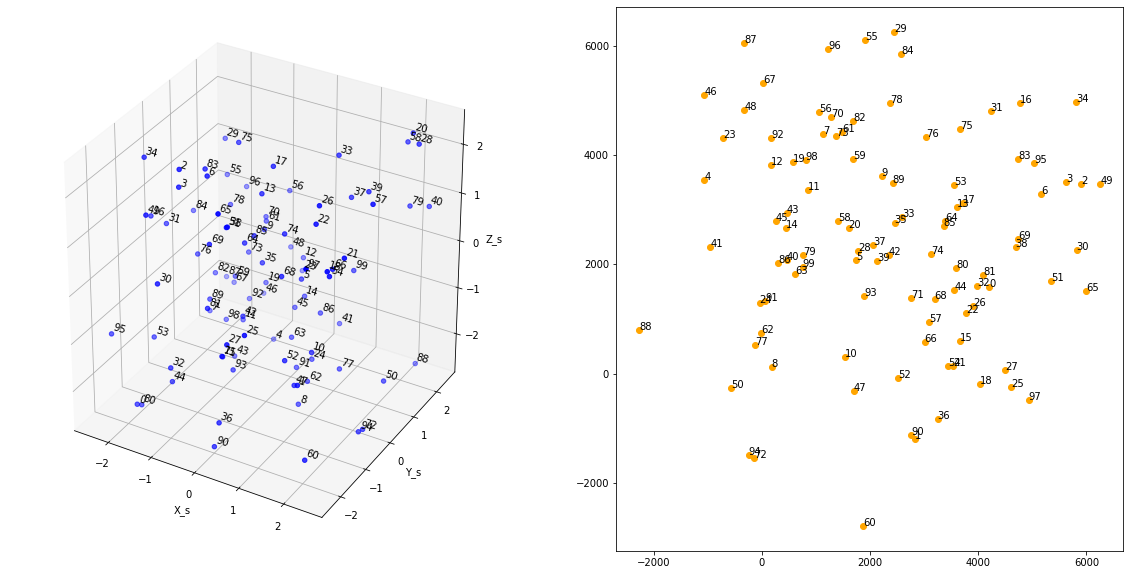

In [ ]:
''' Randomly generate 3D points point with respect to the world '''
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU
from scipy.spatial.transform import Rotation 

np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(precision=3, sci_mode=False)

from scipy.spatial.transform import Rotation as R
''' This class provides an interface to initialize from and represent rotations with: Quaternions
    Rotation Matrices, Rotation Vectors, Modified Rodrigues Parameters, Euler Angles
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html '''

def generate_synthetic_data (N) :

    def forward_projective (p, X_w) :
        '''13 parameters: f/s_x, f/s_y, c_x, c_y, theta_x, theta_y, theta_z, t_x, t_y, t_z, kappa1, kappa2'''
        ''''               0,      1  ,   2  ,  3,   4 ,     5    ,    6   ,    7,  8,  9,     10,   11,   '''
        ''' world-camera coordinate transform'''
    
        def len_distortion (kappa1, kappa2, x, y) :
            ''' applies lens distorion on the principal point centered coordinates x(N,3,1)'''
            r_sq = x**2 + y**2
            distortion_factor = 1 + kappa1*r_sq + kappa2*r_sq*r_sq
            x_hat = x * distortion_factor
            y_hat = y * distortion_factor
            print('kappa: {:0.3e}, {:0.3e}'.format(kappa1, kappa2))
            return (x_hat, y_hat)

        R = Rotation.from_euler('xyz', [[p[4], p[5], p[6]]], degrees=True) 
        print('Rotation (Euler) angles in degrees (xyz):', R.as_euler('xyz', 'degrees'))
        T = np.array([p[7], p[8], p[9]])
        
        RT = np.eye(4)
        RT[0:3,0:3] = R.as_matrix()
        RT[0:3,3] = T
        print('R=\n', R.as_matrix(), '\nT=\n', T, '\nRT=\n', RT)
        p_c_tilde = RT @ X_w

        K  = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]) 
        x = K @ p_c_tilde
        '''Perspective projection'''
        x_c = x[:,0,:]/x[:,2,:] 
        y_c = x[:,1,:]/x[:,2,:] 
        
        ''' Lens distortion'''
        #x_s, y_s = len_distortion(np.power(10, p[10]), np.power(10, p[11]), x_c - p[2], y_c - p[3])
        x_s, y_s = len_distortion(p[10], p[11], x_c, y_c)
        print('Average pixel lens distortion: {:0.3f} pixels'.format(np.sqrt((p[0]*p[0]*(x_c-x_s)**2 + p[1]*p[1]*(y_c-y_s)**2).sum()/X_w.shape[0])))

        x_s = -p[0]*x_s + p[2]; y_s = -p[1]*y_s+ p[3]
        K  = np.array([[-p[0], 0, p[2], 0], [0, -p[1], p[3], 0], [0, 0, 1, 0]]) 
        return (x_s, y_s, K, RT)

    '''12 parameters: f/s_x, f/s_y, c_x, c_y, theta_x, theta_y, theta_z, t_x, t_y, t_z, log10(kappa1), log10(kappa2)'''
    p = np.array([ 0.016/1.22e-6, 0.016/1.22e-6, 2500, 2500, 30, -30, 20, 0, 0, 10, 0.016, 0.0032])
    
    ''' -----------Generate random 3D data --------------------------'''
    X_world = 5*(np.random.rand(N, 4, 1) - 0.5)
    X_world[:,3,0] = np.ones((N,))
    x_s, y_s, K, P = forward_projective (p, X_world)

    return(x_s, y_s, X_world, K[:,0:3], P[0:3,:])


x_image_gt, y_image_gt, X_world_gt, K_gt, RT_gt = generate_synthetic_data (100)
print('K=\n', K_gt)
print('RT=\n', RT_gt)
print('P=\n', K_gt@RT_gt)


# -----------------------------DISPLAY--------------------------------------------
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(X_world_gt[:,0,0], X_world_gt[:,1,0], X_world_gt[:,2,0], c='b', marker='o')
ax.set_xlabel('X_s')
ax.set_ylabel('Y_s')
ax.set_zlabel('Z_s')
N = X_world_gt.shape[0]
for i in range(N):
    ax.text(X_world_gt[i,0,0], X_world_gt[i,1,0], X_world_gt[i,2,0], '{}'.format(i), 'x')
plt.subplot(1,2,2)
plt.plot(y_image_gt, x_image_gt, c='orange', marker='o', linewidth=0);
for i in range(N):
    plt.annotate('{}'.format(i), (y_image_gt[i], x_image_gt[i]));




# Code: Step 1 - Create DLT estimate

In [ ]:
import scipy.sparse.linalg
def DLT_estimate (x, y, X_w) :
    # (x, y) are the 2D image coordinates - x is N by 1 sized; y is N by 1 sized.
    # X_w stored the corresponding 3D pt coordinates in homogeneous form -- N by 4 by 1 sized array

    #print ('x_i size: {}, y_i size: {}, X_world size: {}'.format(x.shape, y.shape, X_w.shape))

    X = X_w.squeeze()
    D_x = np.diag(x.squeeze())
    D_y = np.diag(y.squeeze())
    #print(X.shape, D_x.shape, D_y.shape)

    B_1 = X.transpose(1, 0) @ X
    B_2 = -X.transpose(1, 0) @ D_x @ X
    B_3 = -X.transpose(1, 0) @ D_y @ X
    B_4 = X.transpose(1, 0) @ (D_x**2 + D_y**2) @ X
    #print(B_4)

    A1 = np.column_stack((B_1, np.zeros((4,4)), B_2))
    A2 = np.column_stack((np.zeros((4,4)), B_1, B_3))
    A3 = np.column_stack((B_2, B_3, B_4))
    A_T_A = np.row_stack((A1, A2, A3))

    #print('A =\n', A_T_A)

    vals, vecs = scipy.sparse.linalg.eigs(A_T_A, k=1, which='SM')
    #print('Minimum singular value', np.real(vals[0]))

    p = np.real(vecs)
    return(np.real(vals[0]), p/p[11])

fit_error, P_DLT = DLT_estimate (x_image_gt, y_image_gt, X_world_gt)
print('DLT "error (not geometric)"= {} estimate of P =\n{}'.format(fit_error, P_DLT.reshape(3,4)))

print('P matrix (ground truth) =\n', K_gt @ RT_gt)

DLT "error (not geometric)"= 9.677480828737116e-06 estimate of P =
[[-943.286  805.461  497.466 2499.972]
 [-263.825 -847.862  999.018 2500.088]
 [   0.05     0.043    0.075    1.   ]]
P matrix (ground truth) =
 [[-9422.756  8048.057  4968.623 25000.   ]
 [-2634.566 -8468.847  9979.202 25000.   ]
 [    0.5       0.433     0.75     10.   ]]


# Code: Step 2a. Non-linear refinement of the DLT estimate of the $p_{ij}$'s using Gauss-Newton

* This is the same as the algorithm used to refine 2D perspective projection estimates. The code below is the same as we have seen before, with just names of variables updated to reflect the current problem.

* It used the PyTorch autograd (autodiff) aspect to compute the Jacobian. You could replace it with an hand coded expression for this problem. However, using autograd makes the code more generally applicable.


In [ ]:
from skimage.transform import warp
from skimage import io
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU
#-------------------------------------------------------------------------------
def fit_Gauss_Newton_pytorch (image_x_pts, image_y_pts, world_pts_3D) :

    error_, P_DLT  = DLT_estimate (image_x_pts, image_y_pts, world_pts_3D)
    P_DLT = P_DLT.squeeze()
    print('Initial estimate of P:\n', P_DLT.reshape(3,4))

    X = torch.tensor(world_pts_3D.squeeze().transpose(1, 0), device = device, requires_grad=False) # homogenous coordinates
    X_dash = torch.tensor(np.stack((image_x_pts,image_y_pts), 0).squeeze(), device = device, requires_grad=False) # non-homogenous coordinates
    p_34 = torch.tensor([1], device = device, requires_grad=False) # fixed entry of the homography matrix
    print('Shapes of data: 3D-{}, 2D-{}'.format(X.shape, X_dash.shape))

    def transform (p_11): # just 8 free parameters
        "This is what we want to minimize by varying the h_8."
        "It takes in two inputs, the parameters and the point to compute at"
        P = torch.cat((p_11, p_34), 0)
        X_t = torch.matmul(P.reshape(3,4), X)
        #print(P.reshape(3,4))
        Xt_nh = non_homogeneous (X_t)
        
        Xloss =  loss(Xt_nh)
        return (Xloss)  

    def non_homogeneous (X_in) :
        # X is a 3 by N matrix -- each column is a homogenenous coordinate of a point
        X_out = torch.div(X_in, X_in [2,:]) # normalized homogenous coordinates
        return(X_out [0:2,:])

    def loss (X_t) :
        # Note X_dash is not defined in this function scope
        return(X_dash - X_t)

    def SSD_fit_error (p_11) :
        # Note X is not defined in this function scope
        Xt = transform (p_11)
        return(torch.pow(Xt, 2).sum())

    # initialize the 8 parameters of the perspective transform matrix. Recall, h_22 = 1, hence only 8
    h_ = P_DLT[0:11]   

    #remove an identity matrix as per parameterization convention (p=0, represents the identity matrix) 
    p_11_est = torch.tensor(h_, device = device, requires_grad=True)
    #print('h = \n', p_11_est)

    change_in_residual = 1.0
    old_residual = torch.sqrt(SSD_fit_error(p_11_est)/X.shape[1])

    print('Initial values: h = \n {}\n Starting residual: {}'.format(p_11_est, old_residual))

    while change_in_residual > 0.001:
        'Compute Jacobian'
        J = - torch.autograd.functional.jacobian(transform, p_11_est) # do not understand this is off by a sign?!
        # size of J is torch.Size([2, N_data, 8]) 
        JJ = J.permute(1, 0, 2)   # N_pts by 2 by 8
        J_T = J.permute(1, 2, 0) # N_pts by 8 by 2

        'Compute A -- Hessian'
        A = torch.sum((J_T @ JJ), 0)

        'Compute residual'
        del_r = transform(p_11_est)  # rise of del_r is torch.Size([2, N_data])
        del_r = del_r.permute(1, 0)[:,:,None]  #46 by 2 by 1
        #print('Shapes A {}, J {}, JT {}, delr {}'.format(A.shape, J.shape, J_T.shape, del_r.shape))

        'Compute b vector'        
        b = torch.sum((J_T @ del_r), 0)
        #print('Jacobian=\n', J, 'A=\n', A, 'A2=\n', A2, 'b=\n', b)

        'Compute change in parameter'
        del_p = (torch.inverse(A) @ b).squeeze()
        #del_p = (torch.tensor((np.linalg.inv(A.numpy()/2))) @ b).squeeze()
        #print('A=\n', A , 'invA=\n', torch.inverse(A/2),'\n b=\n', b, torch.inverse(A)@(A),'\n del_p =\n', del_p)

        'Update estimate'
        p_11_est  = p_11_est + del_p

        'Compute new residual and percentage change in residual'
        new_residual = torch.sqrt(SSD_fit_error(p_11_est)/X.shape[1])
        change_in_residual = (old_residual - new_residual)/old_residual
        old_residual = new_residual
        
        print('Residual: {}'.format(new_residual))
        #print('H=\n', torch.cat((p_11_est, p_34), 0).reshape(3, 4))
    
    P = torch.cat((p_11_est, p_34), 0).reshape(3, 4)
    return(new_residual, P.detach().cpu().numpy())

fit_error, P_best = fit_Gauss_Newton_pytorch (x_image_gt, y_image_gt, X_world_gt)
print('\n \nInitial DLT estimate of P =\n', P_DLT.reshape(3,4))
print('\nFinal Projected pixel error (per point):', fit_error.item())
print('Final Gauss-Newton refinement of DLT estimate of P =\n', P_best.reshape(3,4))
print('P matrix (ground truth) =\n', K_gt @ RT_gt)

Initial estimate of P:
 [[-943.286  805.461  497.466 2499.972]
 [-263.825 -847.862  999.018 2500.088]
 [   0.05     0.043    0.075    1.   ]]
Shapes of data: 3D-torch.Size([4, 100]), 2D-torch.Size([2, 100])
Initial values: h = 
 tensor([  -943.286,    805.461,    497.466,   2499.972,   -263.825,   -847.862,
           999.018,   2500.088,      0.050,      0.043,      0.075],
       dtype=torch.float64, requires_grad=True)
 Starting residual: 1.3186603457377757
Residual: 1.301033047823709
Residual: 1.301033043476759

 
Initial DLT estimate of P =
 [[-943.286  805.461  497.466 2499.972]
 [-263.825 -847.862  999.018 2500.088]
 [   0.05     0.043    0.075    1.   ]]

Final Projected pixel error (per point): 1.301033043476759
Final Gauss-Newton refinement of DLT estimate of P =
 [[-943.387  805.406  497.396 2499.982]
 [-263.885 -847.955  998.942 2500.134]
 [   0.05     0.043    0.075    1.   ]]
P matrix (ground truth) =
 [[-9422.756  8048.057  4968.623 25000.   ]
 [-2634.566 -8468.847  9979

# Code: Step 2b. Non-linear refinement of the DLT estimate of the $p_{ij}$'s using the Newton approach (with Hessians)

* This is the same as the algorithm used to refine 2D perspective projection estimates. The code below is the same as we have seen before, with just names of variables updated to reflect the current problem.

* It used the PyTorch autograd (autodiff) aspect to compute the Jacobian and the Hessian. You could replace it with an hand coded expression for this problem. However, using autograd makes the code more generally applicable.


In [ ]:
from skimage.transform import warp
from skimage import io
import torch

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")  # Uncomment this to run on GPU

#-------------------------------------------------------------------------------
def fit_Newton_autograd (image_x_pts, image_y_pts, world_pts_3D) :

    error_, P_DLT  = DLT_estimate (image_x_pts, image_y_pts, world_pts_3D)
    P_DLT = P_DLT.squeeze()
    print('Initial estimate of P:\n', P_DLT.reshape(3,4))

    X = torch.tensor(world_pts_3D.squeeze().transpose(1, 0), device = device, requires_grad=False) # homogenous coordinates
    X_dash = torch.tensor(np.stack((image_x_pts,image_y_pts), 0).squeeze(), device = device, requires_grad=False) # non-homogenous coordinates
    p_34 = torch.tensor([1], device = device, requires_grad=False) # fixed entry of the homography matrix
    #print('Shapes of data: 3D-{}, 2D-{}'.format(X.shape, X_dash.shape))

    def transform (p_11): # just 8 free parameters
        "This is what we want to minimize by varying the h_8."
        "It takes in two inputs, the parameters and the point to compute at"
        P = torch.cat((p_11, p_34), 0)
        X_t = torch.matmul(P.reshape(3,4), X)

        Xt_nh = non_homogeneous (X_t)
        
        Xloss =  loss(Xt_nh)
        return (Xloss)  

    def non_homogeneous (X_in) :
        # X is a 3 by N matrix -- each column is a homogenenous coordinate of a point
        X_out = torch.div(X_in, X_in [2,:]) # normalized homogenous coordinates
        return(X_out [0:2,:])

    def loss (X_t) :
        # Note X_dash is not defined in this function scope
        return(X_dash - X_t)

    def SSD_fit_error (p_11) :
        # Note X is not defined in this function scope
        Xt = transform (p_11)
        return(torch.pow(Xt, 2).sum())

    # initialize the 8 parameters of the perspective transform matrix. Recall, h_22 = 1, hence only 8
    h_ = P_DLT[0:11]   

    #remove an identity matrix as per parameterization convention (p=0, represents the identity matrix) 
    p_11_est = torch.tensor(h_, device = device, requires_grad=True)
    print('h = \n', p_11_est)

    learning_rate = 1
    for t in range(200):
        Hessian = torch.autograd.functional.hessian(SSD_fit_error, p_11_est) # A = 2 J_T @ J

        residual = SSD_fit_error (p_11_est)/X.shape[1]
        # Compute and print residual using operations on Tensors.
        # Now residual is a Tensor of shape (1,)
      
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call H.grad, will be a Tensor holding the gradient of 
        # the loss with respect to entries of H.
        
        residual.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            del_p = learning_rate * torch.inverse(Hessian) @ p_11_est.grad
            p_11_est -= del_p
            if (np.remainder(t, 4) == 0) :
                print(t, np.sqrt(residual.item())) # *.item() gets the scalar value held.
                #print('h.grad = \n', h_8_est.grad, '\n del_p\n', del_p)
            # Manually zero the gradients after updating weights
            p_11_est.grad = None

    P = torch.cat((p_11_est, p_34), 0).reshape(3, 4)
    return(torch.sqrt(residual), P.detach().cpu().numpy())


fit_error, P_best = fit_Newton_autograd (x_image_gt, y_image_gt, X_world_gt)
print('\n \nInitial DLT estimate of P =\n', P_DLT.reshape(3,4))
print('\nFinal Projected pixel error (per point):', fit_error.item())
print('Final Newton refinement of DLT estimate of P =\n', P_best.reshape(3,4))
print('P matrix (ground truth) =\n', K_gt @ RT_gt)

Initial estimate of P:
 [[-940.378  804.119  499.872 2495.33 ]
 [-258.149 -851.982 1009.667 2503.341]
 [   0.052    0.042    0.077    1.   ]]
h = 
 tensor([  -940.378,    804.119,    499.872,   2495.330,   -258.149,   -851.982,
          1009.667,   2503.341,      0.052,      0.042,      0.077],
       dtype=torch.float64, requires_grad=True)
0 12.157639417144065
4 12.082281214948384
8 12.03204354120405
12 11.9986079205049
16 11.976379476507676
20 11.96161254491398
24 11.951807232232557
28 11.94529852313182
32 11.940978974386997
36 11.938112661580332
40 11.936210833617654
44 11.934949020927922
48 11.934111870673616
52 11.93355647495907
56 11.933188010242715
60 11.932943562568175
64 11.932781391261754
68 11.932673803929353
72 11.932602428646398
76 11.932555077069166
80 11.932523663220708
84 11.932502822726006
88 11.93248899677152
92 11.932479824382888
96 11.932473739251016
100 11.932469702260402
104 11.932467024044064
108 11.932465247263668
112 11.932464068513076
116 11.932463286506673


# Code: Step 3. Decompose P into K and R-T matrix using RQ decomposition

Recall that the 3D to 2D perspective projection matrix is composed of the intrinsic parameter matrix $\mathbf{K}$ and extrinsic parameters $\mathbf{R}$  and $\mathbf{t}$.

\begin{equation}
\mathbf{P} = \mathbf{K}^{3 x 3} \begin{bmatrix} \mathbf{R} & \mathbf{t} \end{bmatrix}^{3 x 4} = \begin{bmatrix} \mathbf{K}^{3 x 3} \mathbf{R} &\mathbf{K}^{3 x 3} \mathbf{t} \end{bmatrix}^{3 x 4}
\end{equation}

Note that $\mathbf{K}$ is an upper triangular matrix, and the rotation matrix $\mathbf{R}$ is an orthonormal matrix. We used this property to estimate these matrices by the RQ decomposition method from linear algebra.

See Wikipedia page for more information about RQ decomposition https://en.wikipedia.org/wiki/QR_decomposition#QL,_RQ_and_LQ_decompositions

* The RQ decomposition transforms a matrix A into an upper triangular matrix R (also known as right-triangular) and an orthogonal matrix Q. The only difference from QR decomposition is the order of these matrices.

* QR decomposition is Gram–Schmidt orthogonalization of columns of A starting from the first column.

* RQ decomposition is Gram–Schmidt orthogonalization of rows of A starting from the last row. 

* Note QR or RQ decomposition is unique up to the signs of the rows of R. One way to enforce a unique solution is to ensure positive diagonals of R in a post processing step.


In [ ]:
print('Estimated fit_error: {}, \n P_best=\n {}'.format(fit_error, P_best))
K, R = scipy.linalg.rq(P_best[:,0:3])
D = np.diag(np.sign(np.diag(R)));
R = D @ R; K = K @ D;
t = np.linalg.inv(K) @ P_best[:,3]


def angles_from_rotation (R) :
    sy = np.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular :
        theta_x = np.arctan2(R[2,1] , R[2,2]) 
        theta_y = np.arctan2(-R[2,0], sy)
        theta_z = np.arctan2(R[1,0], R[0,0])
    else :
        theta_x = math.arctan2(-R[1,2], R[1,1])
        theta_y = math.arctan2(-R[2,0], sy)
        theta_z = 0
    return(theta_x, theta_y, theta_z)

print('Estimated RQ prod =\n', K @ R)
print('Estimate K=\n', K, '\n', K/K[2,2])
print('Estimated R=\n', R)
theta_x, theta_y, theta_z = angles_from_rotation(R)
print('Angles: {:0.2f}, {:0.2f}, {:0.2f}'.format(theta_x*180/np.pi, theta_y*180/np.pi, theta_z*180/np.pi))
print('Estimated t=\n', t)

print('\nP matrix (ground truth) =\n', K_gt @ RT_gt)
print('K matrix (ground truth) =\n', K_gt)
print('RT matrix (ground truth) =\n', RT_gt)

Estimated fit_error: 1.301033043476759, 
 P_best=
 [[-943.387  805.406  497.396 2499.982]
 [-263.885 -847.955  998.942 2500.134]
 [   0.05     0.043    0.075    1.   ]]
Estimated RQ prod =
 [[-943.387  805.406  497.396]
 [-263.885 -847.955  998.942]
 [   0.05     0.043    0.075]]
Estimate K=
 [[-1312.883    -0.15    249.799]
 [    0.    -1312.861   250.885]
 [    0.        0.        0.1  ]] 
 [[-13127.261     -1.498   2497.695]
 [     0.    -13127.045   2508.554]
 [     0.         0.         1.   ]]
Estimated R=
 [[ 0.814 -0.531 -0.236]
 [ 0.297  0.729 -0.618]
 [ 0.5    0.432  0.75 ]]
Angles: 29.96, -30.00, 20.02
Estimated t=
 [-0.002  0.006  9.999]

P matrix (ground truth) =
 [[-9422.756  8048.057  4968.623 25000.   ]
 [-2634.566 -8468.847  9979.202 25000.   ]
 [    0.5       0.433     0.75     10.   ]]
K matrix (ground truth) =
 [[-13114.754      0.      2500.   ]
 [     0.    -13114.754   2500.   ]
 [     0.         0.         1.   ]]
RT matrix (ground truth) =
 [[ 0.814 -0.531 -0.2

# Code: Step 4: final full non-linear optimization using pytorch.autograd over all parameters including lens distortions. 

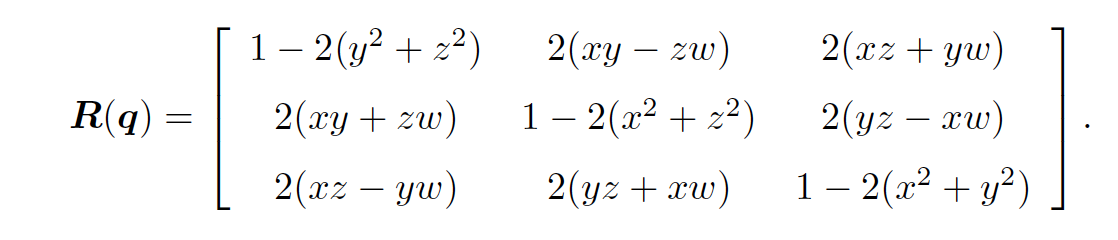

In [ ]:
''' Randomly generate 3D points point with respect to the world '''
from scipy.spatial.transform import Rotation 

def Newton_optimize_non_linear_function (image_x_pts, image_y_pts, world_pts_3D) :

    def forward_projective (p, X_w) :

        def len_distortion (kappa1, kappa2, x, y) :
            ''' applies lens distorion on the principal point centered coordinates x(N,3,1)'''
            r_sq = torch.pow(x, 2) + torch.pow(y, 2)
            distortion_factor = 1 + kappa1*r_sq + kappa2*r_sq*r_sq
            x_hat = x * distortion_factor
            y_hat = y * distortion_factor
            #print('kappa', kappa1, kappa2)
            return (x_hat, y_hat)

        '''14 parameters: (f/s_x, gamma, c_x, f/s_y, c_y,) (q_x, q_y, q_z, q_w) (t_x, t_y, t_z,) (kappa1, kappa2)
                            0,    1  ,   2 ,     3,   4 ,   5 ,  6  , 7,    8,   9,   10   11,     12,     13'''
        ''' world-camera coordinate transform'''
        x = p[5]; y = p[6]; z = p[7]; w = p[8]
        quaternion_mag = torch.sqrt(x*x + y*y + z*z + w*w)
        x = torch.div(x, quaternion_mag) 
        y = torch.div(y, quaternion_mag)
        z = torch.div(z, quaternion_mag) 
        w = torch.div(w, quaternion_mag)

        R_00 =  1 - 2*(y*y + z*z);    R_01 =  2*(x*y - z*w);         R_02 =  2*(x*z + y*w)
        R_10 =  2*(x*y + z*w);        R_11 =  1 - 2*(x*x + z*z);     R_12 =  2*(y*z - x*w) 
        R_20 = 2*(x*z - y*w);          R_21 =  2*(y*z + x*w);        R_22 =  1 - 2*(x*x + y*y)
        #print('R=\n', R_00, R_01, R_02, '\n', R_10, R_11, R_12, '\n', R_20, R_21, R_22)

        X_c = R_00*X_w[0,:] + R_01*X_w[1,:] + R_02*X_w[2,:] + p[9]
        Y_c = R_10*X_w[0,:] + R_11*X_w[1,:] + R_12*X_w[2,:] + p[10]
        Z_c = R_20*X_w[0,:] + R_21*X_w[1,:] + R_22*X_w[2,:] + p[11]
        #print(X_w.shape, X_c.shape, Y_c.shape, Z_c.shape)
    
        '''Perspective projection'''
        x_c = torch.div(X_c, Z_c)
        y_c = torch.div(Y_c, Z_c)
        #print('x_c', x_c)

        ''' Lens distortion'''
        x_s, y_s = len_distortion(p[12], p[13], x_c, y_c)

        ''' multiply by intrinsic transform'''
        x_s = p[0] * x_s + p[1] * y_s + p[2]; 
        y_s = p[3]* y_s + p[4]

        return (x_s, y_s)


    def SSD_error (parameters) :
        # Note X_world_gt, x_image_gt is not defined in this function scope
        x_image, y_image = forward_projective (parameters, X_world_gt)
        error = (torch.pow(x_image - x_image_gt, 2) + 
                 torch.pow(y_image - y_image_gt, 2)).sum()
        return(error)
    
    
    #error_, P_init = DLT_estimate (image_x_pts, image_y_pts, world_pts_3D)
    error_, P_init = fit_Gauss_Newton_pytorch (image_x_pts, image_y_pts, world_pts_3D)

    P_init = P_init.squeeze().reshape(3,4)

    with torch.no_grad():
        # initial estimate of the intrinsic, rotation, and translation parameters
        K, R = scipy.linalg.rq(P_init[:,0:3])
        D = np.diag(np.sign(np.diag(R)));
        R = D @ R; K = K @ D;
        t = np.linalg.inv(K) @ P_best[:,3]
        K = K/K[2,2] # to enforce K[2,2] to 1
        print('K=\n', K, '\n t=\n', t, '\n R=\n', R)

        # using scipy rotation construct to simplify the translations between different representations
        r = Rotation.from_matrix(R)  
        q = r.as_quat()
        #print('Quaternion: ', q)
    
    '''14 parameters: (f/s_x, gamma, c_x, f/s_y, c_y,) (q_x, q_y, q_z, q_w) (t_x, t_y, t_z,) (kappa1, kappa2)
                         0,    1  ,   2 ,     3,   4 ,   5 ,  6  , 7,    8,   9,   10   11,     12,     13'''
    p_k    = torch.tensor([ K[0,0], K[0,1],  K[0,2], K[1,1], K[1,2], q[0], q[1], q[2], q[3], t[0], t[1], t[2], 0.000, 0.000], device=device, dtype=torch.double, requires_grad=True)
    #p_k    = torch.tensor([-0.016/1.22e-6, 0, 2500, -0.016/1.22e-6, 2500, 0.29,  -0.203,  0.228,  0.907, 0, 0, 10, -20, -20], device=device, dtype=torch.double, requires_grad=True)
     
    X_world_gt = torch.tensor(world_pts_3D.squeeze().transpose(1, 0), device = device, requires_grad=False) # homogenous coordinates
    x_image_gt = torch.tensor(image_x_pts.squeeze(), device = device, requires_grad=False) # non-homogenous coordinates
    y_image_gt = torch.tensor(image_y_pts.squeeze(), device = device, requires_grad=False) # non-homogenous coordinates

    
    learning_rate = 0.1
    for t in range (1000):
        Hessian = torch.autograd.functional.hessian(SSD_error, p_k) 
        residual = SSD_error (p_k)/x_image_gt.shape[0]
        residual.backward ()

        with torch.no_grad():
            if (torch.abs(torch.det(Hessian)) > 0) :
                singular_Hessian = 'No'
                del_p = torch.inverse(Hessian) @ p_k.grad
            else:
                singular_Hessian = 'Yes'
                del_p = p_k.grad
            ''' if current residual is lower than previous one -> continue along path or 
                else try lower learning rate and repeat'''
            p_k -= learning_rate * del_p
            p_k.grad = None
            # normalize quaternion
            quaternion_mag = torch.sqrt((p_k[5:9]**2).sum())
            p_k[5:9] = torch.div(p_k[5:9], quaternion_mag)
            if (np.remainder(t, 100) == 0) :
                print('{}: residual: {}, learning rate:{}, singular Hessian:{}, quaternion mag:{}'.format(t, np.sqrt(residual.item()), learning_rate, singular_Hessian, quaternion_mag))
                
    return(residual.detach().numpy(), p_k.detach().numpy())

fit_error, p = Newton_optimize_non_linear_function (x_image_gt, y_image_gt, X_world_gt)
print('\n \nEstimated parameters =\n', p)
print('Estimated K= \n[[{:0.3f}, {:0.3f}, {:0.3f}\n [0, {:0.3f}, {:0.3f}]\n [0, 0, 1]]'.format(p[0], p[1], p[2], p[3], p[4]))
print('Estimated R=')
R_est = Rotation.from_quat(p[5:9])
print(R_est.as_matrix())
print('Euler angles: ', R_est.as_euler('xyz', degrees=True))

#theta_x, theta_y, theta_z = angles_from_rotation(R_est.as_matrix())
#print('Angles:', theta_x*180/np.pi, theta_y*180/np.pi, theta_z*180/np.pi)

print('Estimated t= [{:0.3f}, {:0.3f}, {:0.3f}]'.format(p[9], p[10], p[11]))
print('Estimated kappa_1 = {:0.3e}, kappa_2 = {:0.3e}'.format(np.power(10, p[12]), np.power(10, p[13])))

print('\nP matrix (ground truth) =\n', K_gt @ RT_gt)
print('K matrix (ground truth) =\n', K_gt)
print('RT matrix (ground truth) =\n', RT_gt)


Initial estimate of P:
 [[-943.286  805.461  497.466 2499.972]
 [-263.825 -847.862  999.018 2500.088]
 [   0.05     0.043    0.075    1.   ]]
Shapes of data: 3D-torch.Size([4, 100]), 2D-torch.Size([2, 100])
Initial values: h = 
 tensor([  -943.286,    805.461,    497.466,   2499.972,   -263.825,   -847.862,
           999.018,   2500.088,      0.050,      0.043,      0.075],
       dtype=torch.float64, requires_grad=True)
 Starting residual: 1.3186603974974354
Residual: 1.301033047823642
Residual: 1.301033043476821
K=
 [[-13127.261     -1.498   2497.695]
 [     0.    -13127.045   2508.554]
 [     0.         0.         1.   ]] 
 t=
 [-0.002  0.006  9.999] 
 R=
 [[ 0.814 -0.531 -0.236]
 [ 0.297  0.729 -0.618]
 [ 0.5    0.432  0.75 ]]
0: residual: 1.3010330434769017, learning rate:0.1, singular Hessian:No, quaternion mag:1.0162755155361551
100: residual: 1.1827687755618428, learning rate:0.1, singular Hessian:No, quaternion mag:1.010927925054286
200: residual: 1.0764828585661987, learning